In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import os
import re
import tarfile
import urllib.request

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

### 1. 数据预处理

#### 1.1 定义函数用于删除文字中的 HTML 标签

In [3]:
def rm_tags(text):
    re_tag = re.compile(r'<[^>]+>')
    return re_tag.sub('', text)

#### 1.2 定义函数用于读取 IMDb 文件目录

In [4]:
def read_files(file_type):
    path = 'data/aclImdb/'
    file_list = []
    
    positive_path = path + file_type + '/pos/'
    for f in os.listdir(positive_path):
        file_list += [positive_path + f]
    
    negative_path = path + file_type + '/neg/'
    for f in os.listdir(negative_path):
        file_list += [negative_path + f]
    
    print('read', file_type, 'files:', len(file_list))
    
    all_labels = ([1] * 12500 + [0] * 12500)
    all_texts = []
    for file in file_list:
        with open(file, encoding='utf8') as f:
            all_texts += [rm_tags(" ".join(f.readlines()))]
    
    return all_labels, all_texts

#### 1.3 读取数据集

In [5]:
y_train, train_text = read_files('train')
y_test, test_text = read_files('test')

read train files: 25000
read test files: 25000


#### 1.4 建立 token

In [6]:
token = Tokenizer(num_words=2500)  # 将字典的单词数目增大为2500
token.fit_on_texts(train_text)

#### 1.5 将 "影评文字" 转换成 "数字列表"

In [7]:
x_train_seq = token.texts_to_sequences(train_text)
x_test_seq = token.texts_to_sequences(test_text)

#### 1.6 截长补短让所有 "数字列表" 的长度都为150

In [8]:
x_train = sequence.pad_sequences(x_train_seq, maxlen=150)  # 将"数字列表"的长度增大为150
x_test = sequence.pad_sequences(x_test_seq, maxlen=150)

### 2. 建立模型

#### 2.1 建立 Sequential 模型

In [9]:
model = tf.keras.models.Sequential([

    # 嵌入层
    tf.keras.layers.Embedding(input_length=150, input_dim=2500, output_dim=32),
    tf.keras.layers.Dropout(0.2),
    
    # 平坦层
    tf.keras.layers.Flatten(),
    
    # 隐藏层
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    # 输出层
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

#### 2.2 查看模型的摘要

In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 32)           80000     
_________________________________________________________________
dropout (Dropout)            (None, 150, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1229056   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,309,313
Trainable params: 1,309,313
Non-trainable params: 0
_________________________________________________________________


### 3. 训练模型

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
train_history = model.fit(x=x_train, y=y_train, validation_split=0.2, 
                          epochs=10, batch_size=100, verbose=2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 7s - loss: 0.7333 - acc: 0.6118 - val_loss: 0.9720 - val_acc: 0.0000e+00
Epoch 2/10
 - 7s - loss: 0.6602 - acc: 0.6249 - val_loss: 0.8972 - val_acc: 0.0000e+00
Epoch 3/10
 - 7s - loss: 0.6435 - acc: 0.6264 - val_loss: 0.8620 - val_acc: 0.0000e+00
Epoch 4/10
 - 7s - loss: 0.5559 - acc: 0.6954 - val_loss: 0.5491 - val_acc: 0.7974
Epoch 5/10
 - 8s - loss: 0.4279 - acc: 0.8138 - val_loss: 0.5887 - val_acc: 0.7508
Epoch 6/10
 - 8s - loss: 0.3562 - acc: 0.8525 - val_loss: 0.7679 - val_acc: 0.6756
Epoch 7/10
 - 7s - loss: 0.3118 - acc: 0.8762 - val_loss: 0.5424 - val_acc: 0.8052
Epoch 8/10
 - 7s - loss: 0.2906 - acc: 0.8828 - val_loss: 0.6754 - val_acc: 0.7532
Epoch 9/10
 - 7s - loss: 0.2612 - acc: 0.8962 - val_loss: 0.6275 - val_acc: 0.7494
Epoch 10/10
 - 7s - loss: 0.2439 - acc: 0.9047 - val_loss: 0.4863 - val_acc: 0.8212


### 4. 以图形显示训练过程

In [13]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

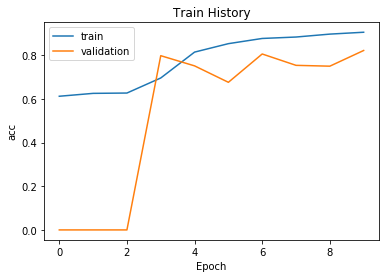

In [14]:
show_train_history(train_history, 'acc', 'val_acc')

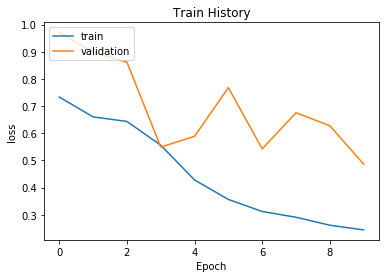

In [15]:
show_train_history(train_history, 'loss', 'val_loss')

### 5. 评估模型的准确率

In [16]:
scores = model.evaluate(x_test, y_test)
print()
print('accuracy:', scores[1])

25000/25000 [==============================] - 2s 96us/step

accuracy: 0.85812


### 6. 进行预测

#### 6.1 执行预测

In [17]:
predictions = model.predict_classes(x_test)

#### 6.2 将预测结果转换为一维数据

In [18]:
predictions = predictions.reshape(-1)

#### 6.3 预测结果

In [19]:
predictions[:10]

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int32)

In [20]:
predictions[12500:12510]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

#### 6.4 对比 "影评文字" 与预测结果

In [21]:
Sentiment_Dict = {1: '正面的', 0: '负面的'}

def display_test_sentiment(idx):
    print('影评文字:')
    print(test_text[idx])
    print()
    print('标签:', Sentiment_Dict[y_test[idx]])
    print('预测结果:', Sentiment_Dict[predictions[idx]])

In [22]:
display_test_sentiment(2)

影评文字:
I really like this show. It has drama, romance, and comedy all rolled into one. I am 28 and I am a married mother, so I can identify both with Lorelei's and Rory's experiences in the show. I have been watching mostly the repeats on the Family Channel lately, so I am not up-to-date on what is going on now. I think females would like this show more than males, but I know some men out there would enjoy it! I really like that is an hour long and not a half hour, as th hour seems to fly by when I am watching it! Give it a chance if you have never seen the show! I think Lorelei and Luke are my favorite characters on the show though, mainly because of the way they are with one another. How could you not see something was there (or take that long to see it I guess I should say)? Happy viewing!

标签: 正面的
预测结果: 正面的


In [23]:
display_test_sentiment(12502)

影评文字:
In Los Angeles, the alcoholic and lazy Hank Chinaski (Matt Dillon) performs a wide range of non-qualified functions just to get enough money to drink and gamble in horse races. His primary and only objective is writing and having sexy with dirty women."Factotum" is an uninteresting, pointless and extremely boring movie about an irresponsible drunken vagrant that works a couple of days or weeks just to get enough money to buy spirits and gamble, being immediately fired due to his reckless behavior. In accordance with IMDb, this character would be the fictional alter-ego of the author Charles Bukowski, and based on this story, I will certainly never read any of his novels. Honestly, if the viewer likes this theme of alcoholic couples, better off watching the touching and heartbreaking Hector Babenco's "Ironweed" or Marco Ferreri's "Storie di Ordinaria Follia" that is based on the life of the same writer. My vote is four.Title (Brazil): "Factotum  Sem Destino" ("Factotum  Without 

### 7. 预测新的影评

#### 7.1 定义用于根据影评文字进行正负面预测的函数

In [24]:
def predict_preview(input_text):
    input_seq = token.texts_to_sequences([input_text])
    pad_input_seq = sequence.pad_sequences(input_seq, maxlen=150)
    predict_result = model.predict_classes(pad_input_seq)
    print(Sentiment_Dict[predict_result[0][0]])

#### 7.2 预测某些新的影评

In [25]:
input_text = '''
It's hard to believe that the same talented director who made the influential cult action classic The Road Warrior had anything to do with this disaster.
Road Warrior was raw, gritty, violent and uncompromising, and this movie is the exact opposite. It's like Road Warrior for kids who need constant action in their movies.
This is the movie. The good guys get into a fight with the bad guys, outrun them, they break down in their vehicle and fix it. Rinse and repeat. The second half of the movie is the first half again just done faster.
The Road Warrior may have been a simple premise but it made you feel something, even with it's opening narration before any action was even shown. And the supporting characters were given just enough time for each of them to be likable or relatable.
In this movie there is absolutely nothing and no one to care about. We're supposed to care about the characters because... well we should. George Miller just wants us to, and in one of the most cringe worthy moments Charlize Theron's character breaks down while dramatic music plays to try desperately to make us care.
Tom Hardy is pathetic as Max. One of the dullest leading men I've seen in a long time. There's not one single moment throughout the entire movie where he comes anywhere near reaching the same level of charisma Mel Gibson did in the role. Gibson made more of an impression just eating a tin of dog food. I'm still confused as to what accent Hardy was even trying to do.
I was amazed that Max has now become a cartoon character as well. Gibson's Max was a semi-realistic tough guy who hurt, bled, and nearly died several times. Now he survives car crashes and tornadoes with ease?
In the previous movies, fuel and guns and bullets were rare. Not anymore. It doesn't even seem Post-Apocalyptic. There's no sense of desperation anymore and everything is too glossy looking. And the main villain's super model looking wives with their perfect skin are about as convincing as apocalyptic survivors as Hardy's Australian accent is. They're so boring and one-dimensional, George Miller could have combined them all into one character and you wouldn't miss anyone.
Some of the green screen is very obvious and fake looking, and the CGI sandstorm is laughably bad. It wouldn't look out of place in a Pixar movie.
There's no tension, no real struggle, or any real dirt and grit that Road Warrior had. Everything George Miller got right with that masterpiece he gets completely wrong here. 
'''

predict_preview(input_text)

负面的


In [26]:
input_text = '''
Sure, I'm a huge film snob who (on the surface) only likes artsy-fartsy foreign films from before the 60's, but that hasn't stopped me from loving Disney's Beauty & The Beast; in fact, it's probably my favorite American animated film and is easily Disney's finest work. It's beautiful, it's breathtaking, it's warm, it's hilarious, it's captivating, and, in Disney fashion, it's magical. When I learned that Disney would be remaking their classic films, B&TB was undeniably the best wrapped package. How could they go wrong?
Oh man, they went wrong.
First thing's first: this film is so flat. The directing was dull and uninteresting throughout the entire film and it honestly felt like one of the Twilight sequels...and then I looked it up and found out that, yes, director Bill Condon was the man behind Breaking Dawn parts 1 & 2. Every shot looks bored and uninterested, which contrasts heavily with the original animated film that was constantly popping with vibrancy. The script too is boring because it's almost a complete remake of the original, though I guess most people won't mind that.
Next: the CGI is horrid. Although I didn't care for The Jungle Book from last year, I could at least admit that the CGI was breathtaking. The same cant be said for this film. Characters like Lumière, Cogsworth, Mrs Potts, and most of the cursed appliances have very strange, lifeless faces that are pretty off putting to be looking at for such a long time. All of the sets too look artificial and fake, especially the town towards the beginning. However, the biggest offender is easily and infuriatingly the character that mattered most: The Beast. The CGI on the Beast's face is so distracting that it completely takes you out of the film. His eyes are completely devoid of soul, and his mouth is a gaping video game black hole of fiction. Klaus Kinski looked much better in the Faerie Tale Theatre episode of Beauty & The Beast, and that was a 1984 TV show episode. But do you know why it looked better? Because it was an actual face with actual eyes, not some video game computerized synthetic monstrosity. When will studios learn that practical effects will always top CGI?
Finally: wasted casting. Emma Watson is beautiful, but she's no Belle. She is completely devoid of the warmth and humanity that made the animated Belle so beloved. Instead, she is cold and heartless throughout most of the film. Kevin Kline is 100% wasted and does nothing except look old. Ian McKellan, Ewan McGregor, Emma Thompson, and even Dan Stevens as the Beast are very expendable and could've been played by anyone else. The only good characters are Gaston and LeFou, mostly because they are fun and played by actors who breathe new life into their original shapes. If anything, this film should've been about Gaston and LeFou, but that would never happen because that would mean Disney couldn't cater to blind nostalgic 90's kids.
Overall, this film is a complete bore. It could've been better if even the special effects were good, but the CGI in particular is horrendous. I'm all for Disney remaking their nostalgia- catering 90's films, but they need to be interesting. This film, sadly, is not. Even the Christmas sequel is better than this film because it's at least something. 
'''

predict_preview(input_text)

负面的


In [27]:
input_text = '''
I was really looking forward to this film. Not only has Disney recently made excellent live-action versions of their animated masterpieces (Jungle Book, Cinderella), but the cast alone (Emma Watson, Ian McKellen, Kevin Kline) already seemed to make this one a sure hit. Well, not so much as it turns out.
Some of the animation is fantastic, but because characters like Cogsworth (the clock), Lumière (the candelabra) and Chip (the little tea cup) now look "realistic", they lose a lot of their animated predecessors' charm and actually even look kind of creepy at times. And ironically - unlike in the animated original - in this new realistic version they only have very limited facial expressions (which is a creative decision I can't for the life of me understand).
Even when it works: there can be too much of a good thing. The film is overstuffed with lush production design and cgi (which is often weirdly artificial looking though) but sadly lacking in charm and genuine emotion. If this were a music album, I'd say it is "over-produced" and in need of more soul and swing. The great voice talent in some cases actually seems wasted, because it drowns in a sea of visual effects that numbs all senses. The most crucial thing that didn't work for me, though, is the Beast. He just never looks convincing. The eyes somehow don't look like real eyes and they're always slightly off.
On the positive side, I really liked Gaston, and the actor who played him, Luke Evans, actually gave the perhaps most energized performance of all. Kevin Kline as Belle's father has little to do but to look fatherly and old, but he makes the most of his part. Speaking of Belle, now that I've seen the film, I think her role was miscast. I think someone like Rachel McAdams would actually have been a more natural, lively and perhaps a bit more feisty Belle than Emma Watson.
If you love the original, you might want to give this one a pass, it's really not that good (although at least the songs were OK). Also, I'd think twice before bringing small children; without cute animated faces, all those "realistic" looking creatures and devices can be rather frightening for a child. 
'''

predict_preview(input_text)

正面的


In [28]:
input_text = '''
Full disclosure, I didn't think the first movie was as bad as it was made out to be. It wasn't good in almost any sense, but it was to be expected given the combination of source material, resources and constraints.
That said, this sequel is 20x better than the first. Having established the characters in the first movie, the actors seem to be able to act now comfortably in their parts. The story becomes much more nuanced with plenty of dynamics on the go.
SPOILERS from now on
Can they maintain a "vanilla" relationship? Is he going to become controlling again and ruin things? Will she let it get out of control and ruin things also or stay on it? Who is that stalky girl and what happened to her exactly? what about his mother? and that ex of his? Will something occur with her infatuated boss?
On top of all of this, I realised while watching that the series was never about a bizarre sadist control freak, it's actually about all men and the story of a woman trying to find the balance between accepting or desiring the dominant behaviour of the male archetype and maintaining strength and independence in such a relationship.
While of course the fact that he is rich, while possibly relating to the power struggle, looks like it is going to be more and more used for generating further drama. The romance is much more evident in this movie to
'''

predict_preview(input_text)

正面的
